<h1 style="text-align:center;">Speech Processing - Speaker Diarization</h1>
<h3 style="text-align:center;">Call Home English Dataset</h3>

In [1]:
from huggingface_hub import notebook_login
notebook_login()

#### **Online Diarization System**

In [2]:
from datasets import load_dataset
ch = load_dataset("diarizers-community/callhome", "eng")
print(ch)

DatasetDict({
    data: Dataset({
        features: ['audio', 'timestamps_start', 'timestamps_end', 'speakers'],
        num_rows: 140
    })
})


In [3]:
import soundfile as sf
import os

# Create the output directory if it doesn't exist
output_dir = "extracted_audio"
os.makedirs(output_dir, exist_ok=True)

# Loop through all audio files in the dataset and save them to the output directory
for idx, audio_data in enumerate(ch["data"]):
    # Extract audio data and sample rate
    audio_array = audio_data["audio"]["array"]
    sample_rate = audio_data["audio"]["sampling_rate"]
    
    # Create output filename
    output_filename = os.path.join(output_dir, f"audio_{idx}.wav")
    
    # Write the audio data to disk
    sf.write(output_filename, audio_array, sample_rate)

    print(f"Saved audio file {output_filename}")

print("All audio files have been extracted.")

Saved audio file extracted_audio\audio_0.wav
Saved audio file extracted_audio\audio_1.wav
Saved audio file extracted_audio\audio_2.wav
Saved audio file extracted_audio\audio_3.wav
Saved audio file extracted_audio\audio_4.wav
Saved audio file extracted_audio\audio_5.wav
Saved audio file extracted_audio\audio_6.wav
Saved audio file extracted_audio\audio_7.wav
Saved audio file extracted_audio\audio_8.wav
Saved audio file extracted_audio\audio_9.wav
Saved audio file extracted_audio\audio_10.wav
Saved audio file extracted_audio\audio_11.wav
Saved audio file extracted_audio\audio_12.wav
Saved audio file extracted_audio\audio_13.wav
Saved audio file extracted_audio\audio_14.wav
Saved audio file extracted_audio\audio_15.wav
Saved audio file extracted_audio\audio_16.wav
Saved audio file extracted_audio\audio_17.wav
Saved audio file extracted_audio\audio_18.wav
Saved audio file extracted_audio\audio_19.wav
Saved audio file extracted_audio\audio_20.wav
Saved audio file extracted_audio\audio_21.wa

#### Load and Preprocess Audio Data

In [4]:
import struct
import wave
import pvcobra
from scipy.io.wavfile import write
import librosa
import numpy as np
from matplotlib import pyplot as plt
import random
import soundfile as sf
import os
from datasets import load_dataset

def read_file(file_name, sample_rate):
    wav_file = wave.open(file_name, mode="rb")
    channels = wav_file.getnchannels()
    num_frames = wav_file.getnframes()

    if wav_file.getframerate() != sample_rate:
        raise ValueError("Audio file should have a sample rate of %d. Got %d" % (sample_rate, wav_file.getframerate()))

    samples = wav_file.readframes(num_frames)
    wav_file.close()

    frames = struct.unpack('h' * num_frames * channels, samples)

    if channels == 2:
        print("Picovoice processes single-channel audio but stereo file is provided. Processing left channel only.")

    return frames[::channels]

# Cobra access key and threshold
access_key = 'RvEwFJ9Xap8Ln6o+u9t5hRMs7Exh81PHsX0z7rapGCN/LGqkVnnl5g=='
threshold = 0.8

# Initialize Cobra VAD
cobra = pvcobra.create(access_key=access_key)
print("Cobra version: %s" % cobra.version)

Cobra version: 2.0.0


#### 1) Voice Activity Detection

In [5]:
# Create the output directory if it doesn't exist
output_dir = "VAD_segments"
os.makedirs(output_dir, exist_ok=True)

# Process each audio file in the dataset
for idx, audio_data in enumerate(ch["data"]):
    # Extract audio data and sample rate
    audio_array = audio_data["audio"]["array"]
    sample_rate = audio_data["audio"]["sampling_rate"]
    
    # Create output subdirectory for this audio file
    audio_output_dir = os.path.join(output_dir, f"audio_{idx}")
    os.makedirs(audio_output_dir, exist_ok=True)
    
    # Save the audio data to a temporary file
    temp_audio_path = os.path.join(audio_output_dir, f"audio_{idx}.wav")
    sf.write(temp_audio_path, audio_array, sample_rate)

    # Read the audio file using the read_file function
    audio = read_file(temp_audio_path, cobra.sample_rate)

    # Perform VAD
    num_frames = len(audio) // cobra.frame_length
    voice_segments = []
    segment = []
    for i in range(num_frames):
        frame = audio[i * cobra.frame_length:(i + 1) * cobra.frame_length]
        result = cobra.process(frame)
        if result >= threshold:
            segment.extend(frame)
        else:
            if segment:
                voice_segments.append(segment)
                segment = []

    if segment:
        voice_segments.append(segment)

    # Save the voice segments
    for seg_idx, segment in enumerate(voice_segments):
        segment = np.array(segment, dtype=np.int16)
        write(os.path.join(audio_output_dir, f"segment_{seg_idx}.wav"), cobra.sample_rate, segment)

    print(f"Processed audio file {idx} and saved {len(voice_segments)} VAD segments.")

# Clean up
cobra.delete()
print("All audio files have been processed and VAD segments saved.")

Processed audio file 0 and saved 99 VAD segments.
Processed audio file 1 and saved 6 VAD segments.
Processed audio file 2 and saved 2 VAD segments.
Processed audio file 3 and saved 5 VAD segments.
Processed audio file 4 and saved 6 VAD segments.
Processed audio file 5 and saved 68 VAD segments.
Processed audio file 6 and saved 7 VAD segments.
Processed audio file 7 and saved 9 VAD segments.
Processed audio file 8 and saved 3 VAD segments.
Processed audio file 9 and saved 58 VAD segments.
Processed audio file 10 and saved 54 VAD segments.
Processed audio file 11 and saved 1 VAD segments.
Processed audio file 12 and saved 205 VAD segments.
Processed audio file 13 and saved 41 VAD segments.
Processed audio file 14 and saved 47 VAD segments.
Processed audio file 15 and saved 1 VAD segments.
Processed audio file 16 and saved 3 VAD segments.
Processed audio file 17 and saved 39 VAD segments.
Processed audio file 18 and saved 189 VAD segments.
Processed audio file 19 and saved 1 VAD segments.

#### 2) MFCC based feature extraction

In [130]:
# Function to extract MFCCs from an audio file
def extract_mfcc(audio_file, sr=16000, n_mfcc=13):
    y, sr = librosa.load(audio_file, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfccs

# Choose a specific audio file and segment for MFCC extraction and visualization
audio_idx = 0  
segment_idx = 0  

segment_file = f'VAD_segments/audio_{audio_idx}/segment_{segment_idx}.wav'
mfccs = extract_mfcc(segment_file, sr=cobra.sample_rate)

#### MFCC Visualization

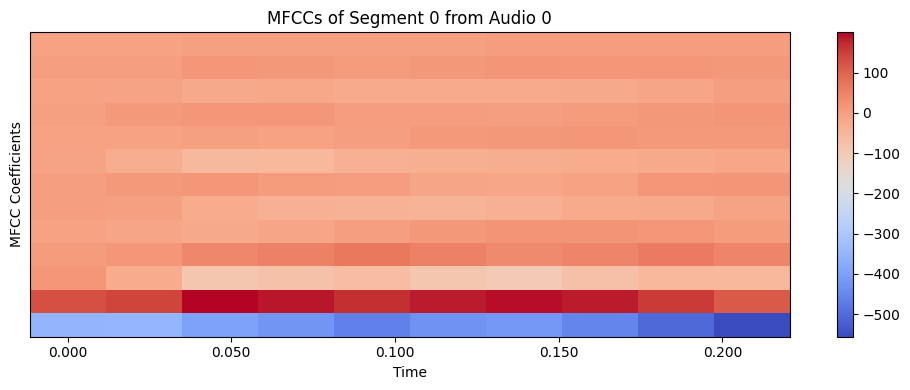

In [131]:
# Plot MFCCs for the chosen segment
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title(f'MFCCs of Segment {segment_idx} from Audio {audio_idx}')
plt.ylabel('MFCC Coefficients')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

#### 3) Speaker Embedding using **deep_speaker**

In [13]:
# Initialize the DeepSpeaker model
from deep_speaker.audio import read_mfcc
from deep_speaker.batcher import sample_from_mfcc
from deep_speaker.constants import SAMPLE_RATE, NUM_FRAMES
from deep_speaker.conv_models_2 import DeepSpeakerModel
from deep_speaker.test import batch_cosine_similarity
import os

# Reproducible results.
np.random.seed(123)
random.seed(123)

# Initialize the DeepSpeaker model
model = DeepSpeakerModel()

# Load pre-trained weights
model.m.load_weights("J:/Speech-Project/ResCNN_triplet_training_checkpoint_265.h5", by_name=True)

# Path to the directory containing VAD segments
output_dir = 'VAD_segments'

# Initialize lists to store speaker embeddings and filenames
embeddings = []
file_names = []

# Iterate over all subdirectories in the VAD_segments directory
for subdir, _, files in os.walk(output_dir):
    for file_name in files:
        # Construct the full file path
        file_path = os.path.join(subdir, file_name)
        
        # Read MFCC features from the VAD segment
        mfcc = sample_from_mfcc(read_mfcc(file_path, SAMPLE_RATE), NUM_FRAMES)
        
        # Get the speaker embedding for the MFCC features
        embedding = model.m.predict(np.expand_dims(mfcc, axis=0))
        
        # Append the embedding and filename to the respective lists
        embeddings.append(embedding)
        file_names.append(file_path)

# Convert lists to numpy arrays
embeddings = np.array(embeddings)
file_names = np.array(file_names)

print("Speaker embeddings have been extracted and stored.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━

In [14]:
# Convert lists to numpy arrays
embeddings = np.array(embeddings)

# Print the shape of the obtained embeddings
print('Shape of speaker embeddings:', embeddings.shape)

Shape of speaker embeddings: (6142, 1, 512)


#### T-SNE Visualization of Speaker Embeddings

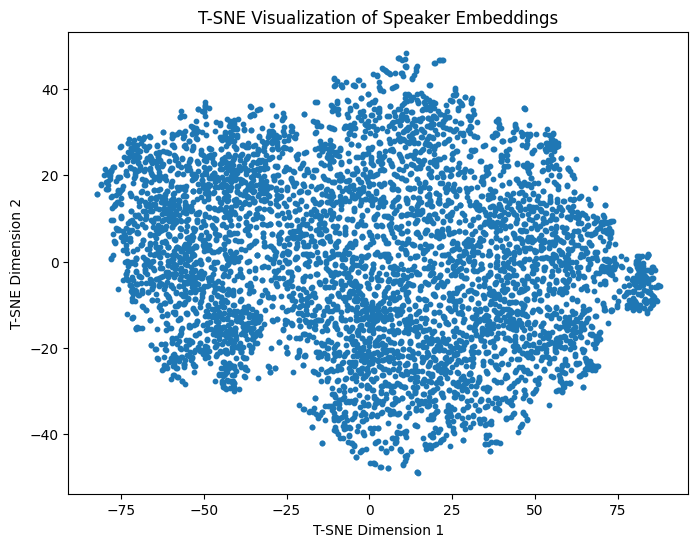

In [15]:
from sklearn.manifold import TSNE

# Flatten the embeddings if needed (remove the singleton dimension)
embeddings = np.squeeze(embeddings)

# Apply T-SNE to reduce dimensions
tsne = TSNE(n_components=2, random_state=123)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the 2D embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=10)
plt.title('T-SNE Visualization of Speaker Embeddings')
plt.xlabel('T-SNE Dimension 1')
plt.ylabel('T-SNE Dimension 2')
plt.show()

#### **4)Clustering**

#### Training and Visualization

In [24]:
import os
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.core import Segment, Annotation

# Function to create ground truth Annotation
def create_groundtruth_annotation(audio_data):
    gt_start_times = audio_data['timestamps_start']
    gt_end_times = audio_data['timestamps_end']
    gt_speakers = audio_data['speakers']
    groundtruth = Annotation()
    for start, end, speaker in zip(gt_start_times, gt_end_times, gt_speakers):
        groundtruth[Segment(start, end)] = speaker
    return groundtruth

# Helper functions
def assign_speaker_ids(cluster_ids):
    unique_clusters, counts = np.unique(cluster_ids, return_counts=True)
    speaker_ids = {cluster: i for i, cluster in enumerate(unique_clusters)}
    return np.array([speaker_ids[cluster] for cluster in cluster_ids])

def speaker_segmentation(speaker_ids):
    segments = []
    current_segment = []
    current_speaker = speaker_ids[0]
    for i, speaker in enumerate(speaker_ids):
        if speaker == current_speaker:
            current_segment.append(i)
        else:
            segments.append((current_segment[0], current_segment[-1], current_speaker))
            current_segment = [i]
            current_speaker = speaker
    segments.append((current_segment[0], current_segment[-1], current_speaker))
    return segments

def calculate_time_index(segments, duration, num_segments):
    time_index = []
    for start, end, speaker in segments:
        start_time = start * (duration / num_segments)
        end_time = (end + 1) * (duration / num_segments)
        time_index.append((start_time, end_time, speaker))
    return time_index

# Function to calculate DER for a single audio file
def calculate_der(segments, groundtruth, duration, num_segments):
    time_index = calculate_time_index(segments, duration, num_segments)
    hypothesis = Annotation()
    for start, end, speaker in time_index:
        hypothesis[Segment(start, end)] = speaker
    metric = DiarizationErrorRate()
    return metric(groundtruth, hypothesis)

# Convert lists to numpy arrays
embeddings = np.array(embeddings).reshape(len(embeddings), -1)
file_names = np.array(file_names)

# Standardize file paths
file_names = np.char.replace(file_names, '\\', '/')

# Debugging: Print the file names for verification
print(file_names)

['VAD_segments/audio_0/audio_0.wav' 'VAD_segments/audio_0/segment_0.wav'
 'VAD_segments/audio_0/segment_1.wav' ...
 'VAD_segments/audio_99/segment_7.wav'
 'VAD_segments/audio_99/segment_8.wav'
 'VAD_segments/audio_99/segment_9.wav']


In [25]:
embeddings.shape

(6142, 512)

#### K-Means Clustering

In [29]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(embeddings)
kmeans_speaker_ids = assign_speaker_ids(kmeans_labels)

#### Gaussian Mixture Model Clustering

In [28]:
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(embeddings)
gmm_speaker_ids = assign_speaker_ids(gmm_labels)

#### Spectral Clustering

In [30]:
spectral = SpectralClustering(n_clusters=2, random_state=42, affinity='nearest_neighbors')
spectral_labels = spectral.fit_predict(embeddings)
spectral_speaker_ids = assign_speaker_ids(spectral_labels)

In [31]:
# Calculate DER for each audio file
der_kmeans_list = []
der_gmm_list = []
der_spectral_list = []

for idx, audio_data in enumerate(ch['data']):
    duration = len(audio_data['audio']['array']) / SAMPLE_RATE
    
    # Get the file names for the current audio file segments
    current_audio_files = [fn for fn in file_names if f'audio_{idx}/' in fn]

    # Debugging: Print the current audio files
    print(f'Processing audio file {idx} with segments:')
    print(current_audio_files)
    
    groundtruth = create_groundtruth_annotation(audio_data)
    
    # Collect speaker IDs for the current audio file segments
    kmeans_speaker_ids_for_file = [kmeans_speaker_ids[file_names.tolist().index(fn)] for fn in current_audio_files]
    gmm_speaker_ids_for_file = [gmm_speaker_ids[file_names.tolist().index(fn)] for fn in current_audio_files]
    spectral_speaker_ids_for_file = [spectral_speaker_ids[file_names.tolist().index(fn)] for fn in current_audio_files]
    
    try:
        kmeans_segments = speaker_segmentation(kmeans_speaker_ids_for_file)
        der_kmeans = calculate_der(kmeans_segments, groundtruth, duration, len(current_audio_files))
        der_kmeans_list.append(der_kmeans)
        
        gmm_segments = speaker_segmentation(gmm_speaker_ids_for_file)
        der_gmm = calculate_der(gmm_segments, groundtruth, duration, len(current_audio_files))
        der_gmm_list.append(der_gmm)
        
        spectral_segments = speaker_segmentation(spectral_speaker_ids_for_file)
        der_spectral = calculate_der(spectral_segments, groundtruth, duration, len(current_audio_files))
        der_spectral_list.append(der_spectral)
    except ValueError as e:
        print(f"Error processing file {audio_file_path}: {e}")

# Print DER results
print("DER results for KMeans:", der_kmeans_list)
print("DER results for GMM:", der_gmm_list)
print("DER results for Spectral Clustering:", der_spectral_list)

Processing audio file 0 with segments:
['VAD_segments/audio_0/audio_0.wav', 'VAD_segments/audio_0/segment_0.wav', 'VAD_segments/audio_0/segment_1.wav', 'VAD_segments/audio_0/segment_10.wav', 'VAD_segments/audio_0/segment_11.wav', 'VAD_segments/audio_0/segment_12.wav', 'VAD_segments/audio_0/segment_13.wav', 'VAD_segments/audio_0/segment_14.wav', 'VAD_segments/audio_0/segment_15.wav', 'VAD_segments/audio_0/segment_16.wav', 'VAD_segments/audio_0/segment_17.wav', 'VAD_segments/audio_0/segment_18.wav', 'VAD_segments/audio_0/segment_19.wav', 'VAD_segments/audio_0/segment_2.wav', 'VAD_segments/audio_0/segment_20.wav', 'VAD_segments/audio_0/segment_21.wav', 'VAD_segments/audio_0/segment_22.wav', 'VAD_segments/audio_0/segment_23.wav', 'VAD_segments/audio_0/segment_24.wav', 'VAD_segments/audio_0/segment_25.wav', 'VAD_segments/audio_0/segment_26.wav', 'VAD_segments/audio_0/segment_27.wav', 'VAD_segments/audio_0/segment_28.wav', 'VAD_segments/audio_0/segment_29.wav', 'VAD_segments/audio_0/segment_

C:\Users\jaysa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


Processing audio file 1 with segments:
['VAD_segments/audio_1/audio_1.wav', 'VAD_segments/audio_1/segment_0.wav', 'VAD_segments/audio_1/segment_1.wav', 'VAD_segments/audio_1/segment_2.wav', 'VAD_segments/audio_1/segment_3.wav', 'VAD_segments/audio_1/segment_4.wav', 'VAD_segments/audio_1/segment_5.wav']
Processing audio file 2 with segments:
['VAD_segments/audio_2/audio_2.wav', 'VAD_segments/audio_2/segment_0.wav', 'VAD_segments/audio_2/segment_1.wav']
Processing audio file 3 with segments:
['VAD_segments/audio_3/audio_3.wav', 'VAD_segments/audio_3/segment_0.wav', 'VAD_segments/audio_3/segment_1.wav', 'VAD_segments/audio_3/segment_2.wav', 'VAD_segments/audio_3/segment_3.wav', 'VAD_segments/audio_3/segment_4.wav']
Processing audio file 4 with segments:
['VAD_segments/audio_4/audio_4.wav', 'VAD_segments/audio_4/segment_0.wav', 'VAD_segments/audio_4/segment_1.wav', 'VAD_segments/audio_4/segment_2.wav', 'VAD_segments/audio_4/segment_3.wav', 'VAD_segments/audio_4/segment_4.wav', 'VAD_segment

#### Model Evaluation

In [32]:
# Calculate the average DER for each clustering method
average_der_kmeans = np.mean(der_kmeans_list)
average_der_gmm = np.mean(der_gmm_list)
average_der_spectral = np.mean(der_spectral_list)

# Print average DER results
print(f"Average Diarization Error Rate (DER) for K-Means: {average_der_kmeans:.4f}")
print(f"Average Diarization Error Rate (DER) for GMM: {average_der_gmm:.4f}")
print(f"Average Diarization Error Rate (DER) for Spectral Clustering: {average_der_spectral:.4f}")

Average Diarization Error Rate (DER) for K-Means: 0.5902
Average Diarization Error Rate (DER) for GMM: 0.5727
Average Diarization Error Rate (DER) for Spectral Clustering: 0.5956


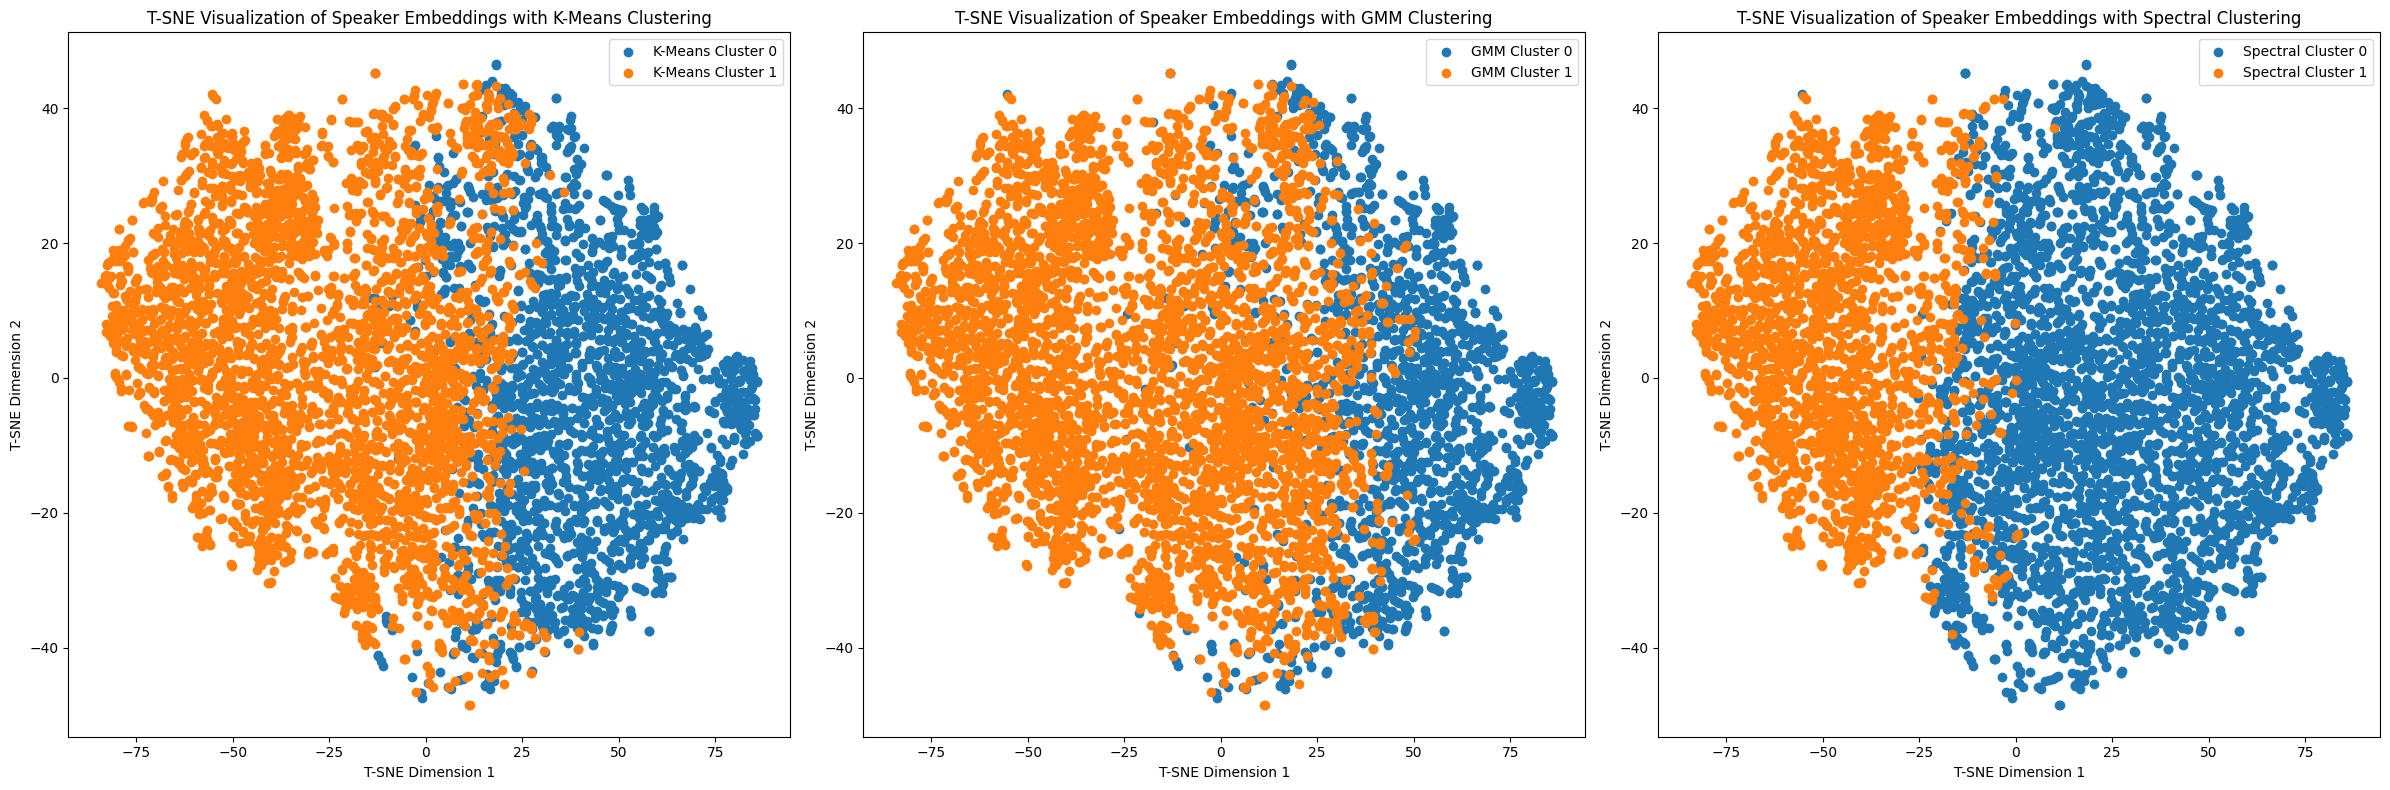

In [33]:
# T-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot clusters for K-Means, GMM, and Spectral Clustering in subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot clusters for K-Means
axes[0].scatter(embeddings_2d[kmeans_labels == 0, 0], embeddings_2d[kmeans_labels == 0, 1], label='K-Means Cluster 0')
axes[0].scatter(embeddings_2d[kmeans_labels == 1, 0], embeddings_2d[kmeans_labels == 1, 1], label='K-Means Cluster 1')
axes[0].set_title('T-SNE Visualization of Speaker Embeddings with K-Means Clustering')
axes[0].set_xlabel('T-SNE Dimension 1')
axes[0].set_ylabel('T-SNE Dimension 2')
axes[0].legend()

# Plot clusters for GMM
axes[1].scatter(embeddings_2d[gmm_labels == 0, 0], embeddings_2d[gmm_labels == 0, 1], label='GMM Cluster 0')
axes[1].scatter(embeddings_2d[gmm_labels == 1, 0], embeddings_2d[gmm_labels == 1, 1], label='GMM Cluster 1')
axes[1].set_title('T-SNE Visualization of Speaker Embeddings with GMM Clustering')
axes[1].set_xlabel('T-SNE Dimension 1')
axes[1].set_ylabel('T-SNE Dimension 2')
axes[1].legend()

# Plot clusters for Spectral Clustering
axes[2].scatter(embeddings_2d[spectral_labels == 0, 0], embeddings_2d[spectral_labels == 0, 1], label='Spectral Cluster 0')
axes[2].scatter(embeddings_2d[spectral_labels == 1, 0], embeddings_2d[spectral_labels == 1, 1], label='Spectral Cluster 1')
axes[2].set_title('T-SNE Visualization of Speaker Embeddings with Spectral Clustering')
axes[2].set_xlabel('T-SNE Dimension 1')
axes[2].set_ylabel('T-SNE Dimension 2')
axes[2].legend()

plt.tight_layout()
plt.show()